# correlation between outlook and pph probs (by year or even date? on MDT+, SLGT+, and all)

In [99]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# load grid pph and outlook
binary_reports = False
if binary_reports:
    pph = xr.open_dataset('data/storm_reports/grid_reports.nc')
    pph_dummy = xr.open_dataset('data/pph/labelled_pph.nc')
else:
    pph = xr.open_dataset('data/pph/labelled_pph.nc')
grid_outlooks = xr.open_dataset('~/Downloads/grid_outlooks.nc')


In [101]:
if binary_reports:
    pph_key_dict = {
        'Wind': 'Wind',
        'Hail': 'Hail',
        'Tornado': 'Tornado',
        'All Hazard': 'Total Reports'
    }

else:
    pph_key_dict = {
        'Wind': 'p_perfect_wind',
        'Hail': 'p_perfect_hail',
        'Tornado': 'p_perfect_tor',
        'All Hazard': 'p_perfect_totalsvr'
    }

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}

In [102]:
# correlations between outlook and pph probs (within year, by hazard (each hazard is different color on plot)
missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000']
pph = pph.sel(time=~pph['time'].isin(missing_dates))
if binary_reports:
    pph_dummy = pph_dummy.sel(time=~pph_dummy['time'].isin(missing_dates))
grid_outlooks = grid_outlooks.sel(time=~grid_outlooks['time'].isin(missing_dates))

day3_dates = pph['time'][pph['time'] >= '200203300000']
pph = pph.sel(time = day3_dates)
if binary_reports:
    pph_dummy = pph_dummy.sel(time = day3_dates)
grid_outlooks = grid_outlooks.sel(time = day3_dates)

if binary_reports:
    mdt_dates = pph_dummy['time'][pph_dummy['MAX_CAT'].isin(['MDT', 'HIGH'])]
else:
    mdt_dates = pph['time'][pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_pph = pph.sel(time = mdt_dates)
mdt_outlooks = grid_outlooks.sel(time = mdt_dates)

mod = False
if mod:
    curr_pph = mdt_pph
    curr_outlooks = mdt_outlooks
else:
    curr_pph = pph
    curr_outlooks = grid_outlooks       


In [103]:
mask = np.load('conus_mask.npy', allow_pickle=True)
regions = ['West', 'Great Plains', 'Midwest', 'South', 'Northeast', 'CONUS']
valid_mask = np.isin(mask, regions)

In [104]:
years = np.arange(2002, 2024)
hazards = ['All Hazard', 'Wind', 'Hail', 'Tornado']

results = []

for year in years:
    year_str = str(year)

    # Subset to the times within this year
    pph_year = curr_pph.sel(time=curr_pph.time.str.startswith(year_str))
    out_year = curr_outlooks.sel(time=curr_outlooks.time.str.startswith(year_str))

    for hazard in hazards:
        pph_key = pph_key_dict[hazard]
        out_key = outlook_key_dict[hazard]

        # Extract fields
        if binary_reports:
            pph_vals = pph_year.sel(hazard = pph_key)['bool'].values[:, valid_mask]
        else:
            pph_vals = pph_year[pph_key].values[:, valid_mask]
        out_vals = out_year['prob'].sel(outlook=out_key).values[:, valid_mask]

        # Flatten to 1D arrays (time * selected gridpoints)
        pph_flat = pph_vals.ravel()
        out_flat = out_vals.ravel()

        corr, _ = pearsonr(pph_flat, out_flat)

        results.append({'year': year, 'hazard': hazard, 'correlation': corr})

# Final DataFrame for plotting
df_corr = pd.DataFrame(results)

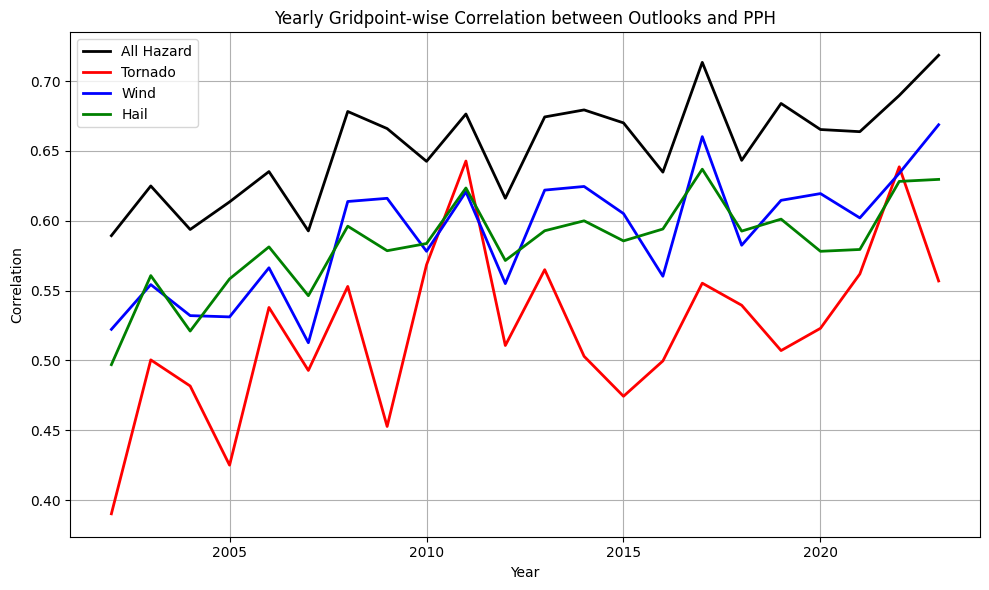

: 

In [ ]:
color_map = {
    'All Hazard': 'black',
    'Tornado': 'red',
    'Wind': 'blue',
    'Hail': 'green'
}

plt.figure(figsize=(10, 6))

for hazard in ['All Hazard', 'Tornado', 'Wind', 'Hail']:
    subset = df_corr[df_corr['hazard'] == hazard]
    plt.plot(
        subset['year'],
        subset['correlation'],
        label=hazard,
        color=color_map[hazard],
        linewidth=2
    )

plt.xlabel('Year')
plt.ylabel('Correlation')
if mod and binary_reports:
    plt.title('Yearly Gridpoint-wise Correlation between Outlooks and Truth on MDT+ Days')
elif mod:
    plt.title('Yearly Gridpoint-wise Correlation between Outlooks and PPH on MDT+ Days')
elif binary_reports:
    plt.title('Yearly Gridpoint-wise Correlation between Outlooks and Truth')
else:
    plt.title('Yearly Gridpoint-wise Correlation between Outlooks and PPH')
plt.legend()
plt.grid(True)
plt.tight_layout()
if binary_reports:
    bin_str = 'binary_'
else:
    bin_str = ''
if mod:
    mod_str = 'mdt_'
else:
    mod_str = 'all_'
plt.savefig('plots/correlation/' + bin_str + mod_str + 'correlation_by_year.png')
plt.show()